Author: Muhammad Ammad-ud-din

Place: Helsinki, Finland

# Driving Behaviour Analysis

## Segmentation: goals and challenges
Segmentation (or technically knowns as clustering) is a machine learning problem where the goal is to learn a generative model (function and its parameters) in a unsupervised setting such that given a set of users having multi-dimensional features, predict for each user its cluster or segment membership. The development of robust and efficient segementation models is a two-fold data science approach: (1) data exploration, (2) machine learning model selection and evaluation.

As a first step, exploratory analysis of the data is essential to gain insights into the problem as well as into the data and to identify the underlying modeling challenges. Moreover, data exploration also helps to formulate the appropriate modeling assumptions and experimental design while considering the resources at hand. As a second step, selection of the optimal model is crucial such that it generalizes to the new data. The optimal model can be selected based on the performance metric obtained through rigorous evaluation of the modeling assumptions using a principled experimental design.

In [1]:
#import libraries necessary for this project

import numpy as np
import pandas as pd
import copy
import itertools
from IPython.display import display # Allows the use of display() for DataFrames


# pretty inline display for jupyter notebooks
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

# import libraries that support data science tasks
from scipy import linalg
from sklearn.decomposition import PCA
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
np.random.seed(1606)

In [2]:
#some auxiliary functions to support visualization and analysis task

def visualizePCAResults(good_data, pca):
    # Dimension indexing
    dimensions = dimensions = ['Component {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)



def visualizeBiPlot(good_data, reduced_data, pca):
    
    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the pca data    
    ax.scatter(x=reduced_data.loc[:, 'Component 1'], y=reduced_data.loc[:, 'Component 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Component 1", fontsize=14)
    ax.set_ylabel("Component 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax
    

def visualizeSegments(X, Y_, means, covariances, index, title):
    
    plt.figure(figsize=(10,8))
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        
        #print(covar)
        #covar=np.diag(covar) 
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-3., 5.)
    plt.ylim(-3., 5.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

#the above function has been adopted/ taken from sklearn code examples.

## Exploratory Analysis of the Data

Understanding data through exploration is the key to every data science problem. Exploration helps to develop hypothesis on the data generation process and to formulate approriate assumptions for the modelling task. 

1. I started looking at the data dimensionalities and noticed that the data contains 165 samples and 5 features in addition to one meta-data feature namely CarID. 
2. Since there are very few features, the visual inspection already showed that the data ranges are quite different. Some features have values in very high range while other features have values in lower ranges (Remark: need some standardization to remove the feature induced biases or artifacts!)
3. Another important finding form the data exploration is about the particular values of the features. Certainly the negative or zero values would not make any sense (e.g., fuel consumption or distance or Speed cannot be negative) in this problem and should be assumed as measurement errors and should be discarded from the data. Hence, I removed samples with negative or zero values in addition to missing or null values. 
4. To further understand the structure or potential relationhsips that could exist in the data, 
        i. I explored the pairwise distribution of features across the dataset to get hints on features which are correlated or have some type of associations. 
        ii. I also studied the PCA analysis of the dataset to further investigate the joint variations of features. 

Remark: in practice all the data exploration should be done on training data only, however, for the sake of this assignment I was willing to welcome some over-fitting!

In [3]:
# load the car data dataset
try:
    drivingData = pd.read_csv("Car_data.txt", delimiter="\t",decimal=",",encoding='utf-8',na_values=[' '])
    print("Car dataset has {} samples with {} features each.".format(*drivingData.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Car dataset has 165 samples with 6 features each.


In [4]:
#quick visual analysis of the few samples
drivingData.head(10)

,CarID,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
0,1,65.17,95.46,"9,09",516.67,13.64
1,2,36.04,90.12,"7,68",511.48,14.01
2,3,30.97,84.79,"7,78",445.72,14.54
3,4,65.17,95.46,"9,09",516.67,14.34
4,5,38.57,86.51,"8,78",499.45,13.95
5,6,30.97,72.62,"8,39",313.19,14.50
6,7,65.17,98.93,"9,21",419.93,13.92
7,8,28.44,78.26,"7,75",396.13,14.14
8,9,30.97,83.46,"7,72",411.23,14.32
9,10,55.04,94.75,"8,71",448.91,14.42


In [5]:
drivingData['Average fuel consumption'] = [str(x).replace(',', '.') for x in drivingData['Average fuel consumption']]
drivingData['Average fuel consumption'] = drivingData['Average fuel consumption'].astype(float)

In [6]:
#set index to CarID column
drivingData.set_index(['CarID'], inplace=True)
drivingData.head(5)

,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
CarID,,,,,
1,65.17,95.46,9.09,516.67,13.64
2,36.04,90.12,7.68,511.48,14.01
3,30.97,84.79,7.78,445.72,14.54
4,65.17,95.46,9.09,516.67,14.34
5,38.57,86.51,8.78,499.45,13.95


In [7]:
# display a description of the dataset
display(drivingData.describe())

,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
count,165.000000,165.000000,164.000000,164.000000,165.000000
mean,41.867576,85.266727,8.372805,439.258841,14.104909
std,10.966468,20.822993,0.830497,78.059607,0.280547
min,0.000000,-98.710000,0.000000,0.000000,13.620000
25%,32.240000,83.360000,7.770000,401.577500,13.910000
50%,41.100000,88.480000,8.590000,441.840000,14.100000
75%,49.970000,92.840000,8.825000,477.517500,14.330000
max,67.700000,112.200000,9.300000,612.500000,14.600000


In [8]:
#check for NaN or missing values
drivingData.isnull().sum()

Average Speed               0
Max Speed                   0
Average fuel consumption    1
Distance                    1
Battery Charging Voltage    0
dtype: int64

In [9]:

#drop rows having NaN or missing values
drivingData.dropna(inplace=True)
print(drivingData.shape)
drivingData.head(5)

(163, 5)


,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
CarID,,,,,
1,65.17,95.46,9.09,516.67,13.64
2,36.04,90.12,7.68,511.48,14.01
3,30.97,84.79,7.78,445.72,14.54
4,65.17,95.46,9.09,516.67,14.34
5,38.57,86.51,8.78,499.45,13.95


In [10]:
#drop duplicated rows
drivingData.drop_duplicates(inplace=True)
print(drivingData.shape)
drivingData.head(5)

(163, 5)


,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
CarID,,,,,
1,65.17,95.46,9.09,516.67,13.64
2,36.04,90.12,7.68,511.48,14.01
3,30.97,84.79,7.78,445.72,14.54
4,65.17,95.46,9.09,516.67,14.34
5,38.57,86.51,8.78,499.45,13.95


In [11]:
drivingData=drivingData[(drivingData > 0).all(1)]

In [12]:
drivingData.shape

(157, 5)

In [13]:
drivingData.head(5)

,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
CarID,,,,,
1,65.17,95.46,9.09,516.67,13.64
2,36.04,90.12,7.68,511.48,14.01
3,30.97,84.79,7.78,445.72,14.54
4,65.17,95.46,9.09,516.67,14.34
5,38.57,86.51,8.78,499.45,13.95


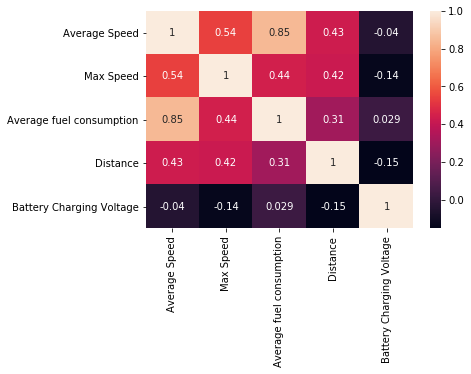

In [14]:
# produce a feature-wise correlation heatmap of the dataset
sns.heatmap(drivingData.corr(), annot=True)

A key observation from the feature-wise scatter plot is that there exist outliers in features: Max Speed and Distance. Usually the clustering models are sensitive to outliers, probably good to remove these outlier samples. 

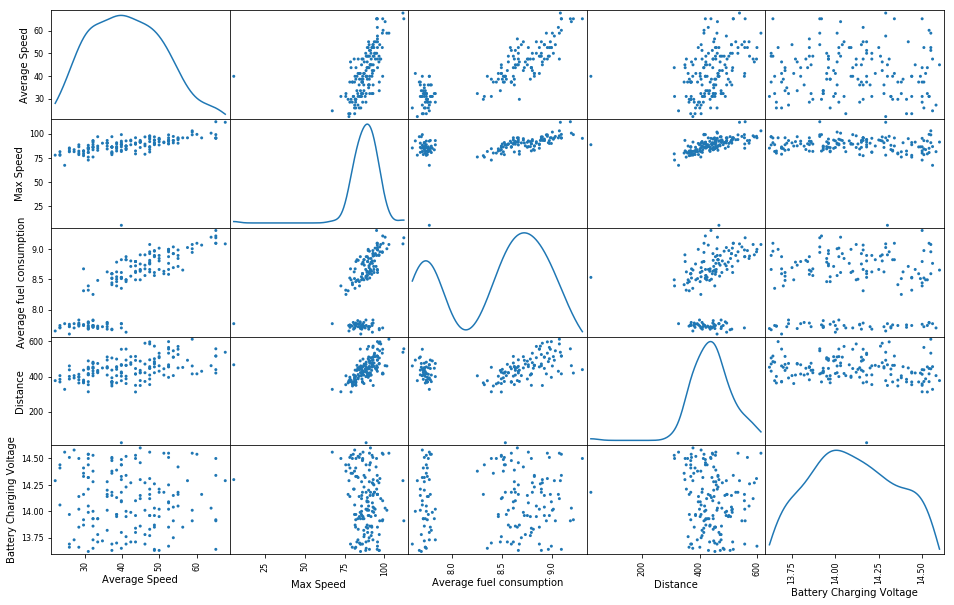

In [15]:
# produce a scatter plot matrix for each pair of features in the data
pd.plotting.scatter_matrix(drivingData, alpha=1,figsize = (16,10), diagonal = 'kde');

## What are the modeling challenges(?):
In the proposed problem, exploratory analysis of the data identifies three fundamental modeling challenges:

1. Small sample-size, diverse feature-level distributions
2. Clear structure or pattern is not obvious from the observed data
3. No ground truth is available on the true number of segments



## What is my solution(?):
To solve the challenges mentioned above, my solution combines three machine learning principles:

1. Data Cleaning, Normalization and Standardization,
2. Data transformation to lower-dimensional space to reveal the hidden structure and pattern,
3. Automatic model complexity selection using Bayesian GMM


### 1. Data Cleaning, Normalization and Standardization
As a normalization step, element-wise natural log is taken of the complete dataset, where the goal was to make the feature values comparable such that the variation in higher values do not tend the models to be biased towards these values. 
Next as a standardization step, to balance the feature-wise scales, z-transformation was performed. After this standardization each features has mean=0 and standard deviation=1 meaning all features have equal scales/ranges. In other words, while doing this standardization I aprior assume that all features are equally important. Though the data exploration steps revealed potential relevant features, I intended to adopt a purely data-driven approach and letting the models choose the best features. On the contrary, datasets/problems comprising of a large number of features and very small sample sizes, I would make use of the data exploration results and any prior knowledge (available from the expert) to be included in the model in a more systematic way.
Additionally, as data cleaning steps, I considered samples whose feature values are 2.5 times greater than the interquartile range (comprising of 25th and 75th percentile of the specific feature values) as outliers and were removed from the collection. 

### 2. Data transformation to lower-dimensional space to reveal the hidden structure and pattern
#### Principal Component Analysis (PCA):
In the realm of small sample-sized datasets, it is statistically challenging to infer model parameters accurately and more advanced machine learning models can be developed that favor sparse solutions (imposing regularization that shuts down the unnecessary features). Alternatively, dimensionality reduction is a more straightforward and ready-to-implement solution. To this end, matrix factorization has evolved as the state-of- art tool for dimensionality reduction and data visualization. Essentially Principal Component Analysis (PCA) is a matrix factorization approach that decomposes the observed data into multiple low-dimensional latent factors (also known as “components”). The underlying assumption is that the combination of multiple latent factors has generated the observed data, corrupted with some noise. However, each combination has generated some parts of the data. The machine learning aim is then to learn these components thereby capturing the strongest variation patterns for individual features in a principled way. In this way, the latent factors can then be seen as “noise-free” low-dimensional representation of the data and the replacement for noisy features. Moreover studying the latent reprsentation can also help reveal useful patterns hidden in the data.

### 3. Automatic model complexity selection using Bayesian GMM
#### Bayesian Gaussian Mixture Models: 
A Gaussian mixture model (GMM) is one of the most widely used generative models in machine learning. Essentially, GMM is a latent variable model assuming that the observed data points are generated from a mixture of a latent Gaussian distributions with unknown parameters (mean and variance). The latent variables or components are then inferred using an Expectation Maximization EM algorithm.  The Bayesian variant of the GMM model allows assuming priors for the unknown mean and variance parameter of each component and instead of point estimates, yields full posterior distributions over the latent variables. 

In a generative machine learning model (for instance GMM), latent variables or components represents the our prior beliefs about the model structure and the underlying data generation process. Since we have little knowledge about the real-world process and the degree of noise that has corrupted the data, it is difficult to choose suitable components apriori (in other words fixing true model complexity apriori). We have to resort to optimization methods to supplement our beliefs on the potentially appropriate choices of the compoennts. The performance and generalisation properties of model is very dependent on chosen model complexity. As the number of features grow or shrink in size, the model complexity selection becomes more challenging. 

A classical approach to estimate number of components is Cross-Validation (CV). Here, I used CV as a comparision approach to  automatic component selection. I partitioned the given data into training (90%) and held-out set (10% to be used for validation purpose), randomly. In practice, I performed 10-fold cross-validation (CV) on the training data, wherein each fold of the CV run, 1/10th of the data was held-out as a validation set at random, while the model was trained on the other 9/10 sets.  Lastly, predictive scores (here per-test sample average log-likelihood) were computed across the predictions obtained from a complete round of CV experiment. And the components were selected that maxmimized the predctive scores.

On the contrary to classical CV approach, Bayesian machionary provides framework for automatic component selection. In practice, we assume suitable prior distribution on the latent variables or components and estimate the posterior distribution using the data likelihood guided by the prior. Specifically, sparse prior  (e.g., Dirichlet process prior, Laplace or Cauchy) guide the inference procedure to extract relevant sturcture from the data and restrict the number of components that are truly needed to capture the variation in the data. In other words, excessive components are automatically shut-down (or push to zero) during the inference process. In this way, even if we choose a higher number of components, the model will learn the true components in a data-driven manner. 

# 1. Data Cleaning, Normalization and Standardization

In [16]:
normalizedDrivingData = copy.deepcopy(drivingData)
normalizedDrivingData = normalizedDrivingData.applymap(np.log)
normalizedDrivingData = (normalizedDrivingData-normalizedDrivingData.mean())/normalizedDrivingData.std()
normalizedDrivingData.head(5)

,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
CarID,,,,,
1,1.864447,0.403962,1.286670,0.651938,-1.659016
2,-0.458020,0.162233,-1.460068,0.614965,-0.318312
3,-1.052429,-0.093771,-1.249253,0.110988,1.541719
4,1.864447,0.403962,1.286670,0.651938,0.847909
5,-0.192023,-0.009441,0.721231,0.527802,-0.533300


In [17]:
normalizedDrivingData.std()

Average Speed               1.0
Max Speed                   1.0
Average fuel consumption    1.0
Distance                    1.0
Battery Charging Voltage    1.0
dtype: float64

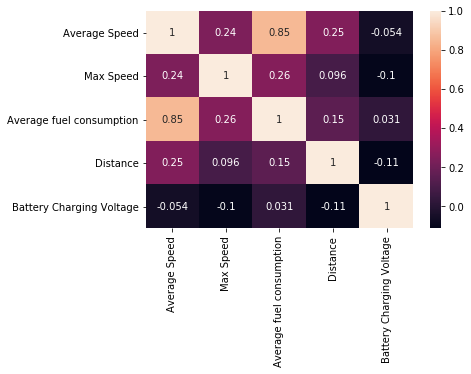

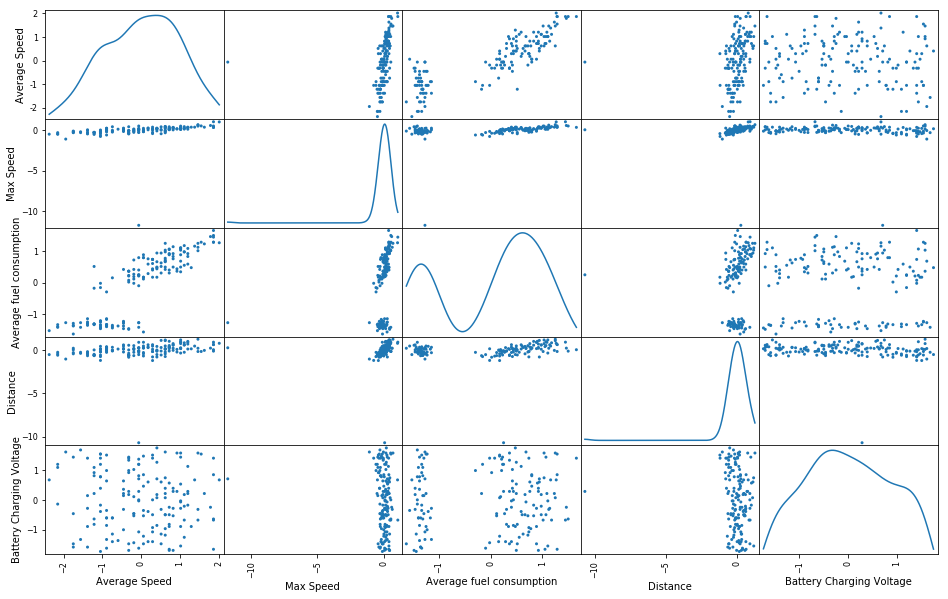

In [18]:
# produce a feature-wise correlation heatmap of the dataset
sns.heatmap(normalizedDrivingData.corr(), annot=True)

# produce a scatter plot matrix for each pair of features in the data
pp = pd.plotting.scatter_matrix(normalizedDrivingData, alpha=1,figsize = (16,10), diagonal = 'kde')

In [19]:
# Select the indices for data points you wish to remove
outliers_lst  = []

# For each feature find the data points with extreme high or low values
for feature in normalizedDrivingData.columns:
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(normalizedDrivingData.loc[:, feature], 20)

    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(normalizedDrivingData.loc[:, feature], 80)

    # TODO: Use the interquartile range to calculate an outlier step (2.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)

    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))

    # The tilde sign ~ means not
    # So here, we're finding any points outside of Q1 - step and Q3 + step
    outliers_rows = normalizedDrivingData.loc[~((normalizedDrivingData[feature] >= Q1 - step) & (normalizedDrivingData[feature] <= Q3 + step)), :]
    display(outliers_rows)

    outliers_lst.append(list(outliers_rows.index))

outliers = list(itertools.chain.from_iterable(outliers_lst))

# List of unique outliers
# We use set()
# Sets are lists with no duplicate entries
uniq_outliers = list(set(outliers))

# List of duplicate outliers
dup_outliers = list(set([x for x in outliers if outliers.count(x) > 1]))

print('Outliers list:\n', uniq_outliers)
print('Length of outliers list:\n', len(uniq_outliers))

print('Duplicate list:\n', dup_outliers)
print('Length of duplicates list:\n', len(dup_outliers))

# Remove duplicate outliers
processedDrivingData = copy.deepcopy(normalizedDrivingData)

processedDrivingData.drop(uniq_outliers, inplace=True)

# Original Data 
print('Original shape of data:\n', normalizedDrivingData.shape)
# Processed Data
print('New shape of data:\n', processedDrivingData.shape)

Data points considered outliers for the feature 'Average Speed':


,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
CarID,,,,,


Data points considered outliers for the feature 'Max Speed':


,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
CarID,,,,,
80,-0.065007,-11.783806,-1.270212,0.281,0.707987


Data points considered outliers for the feature 'Average fuel consumption':


,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
CarID,,,,,


Data points considered outliers for the feature 'Distance':


,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
CarID,,,,,
59,-0.065007,0.085111,0.250495,-10.707927,0.285859


Data points considered outliers for the feature 'Battery Charging Voltage':


,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
CarID,,,,,


Outliers list:
 [80, 59]
Length of outliers list:
 2
Duplicate list:
 []
Length of duplicates list:
 0
Original shape of data:
 (157, 5)
New shape of data:
 (155, 5)


In [20]:
#processedDrivingData.index.names = ['CarID']
processedDrivingData.head(5)


,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
CarID,,,,,
1,1.864447,0.403962,1.286670,0.651938,-1.659016
2,-0.458020,0.162233,-1.460068,0.614965,-0.318312
3,-1.052429,-0.093771,-1.249253,0.110988,1.541719
4,1.864447,0.403962,1.286670,0.651938,0.847909
5,-0.192023,-0.009441,0.721231,0.527802,-0.533300


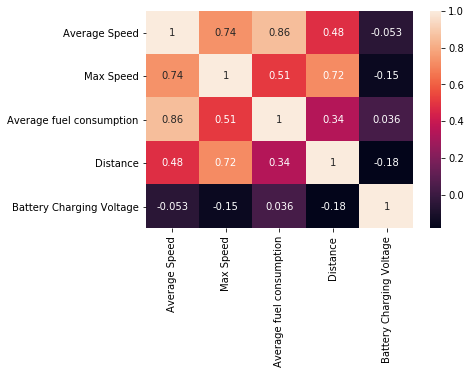

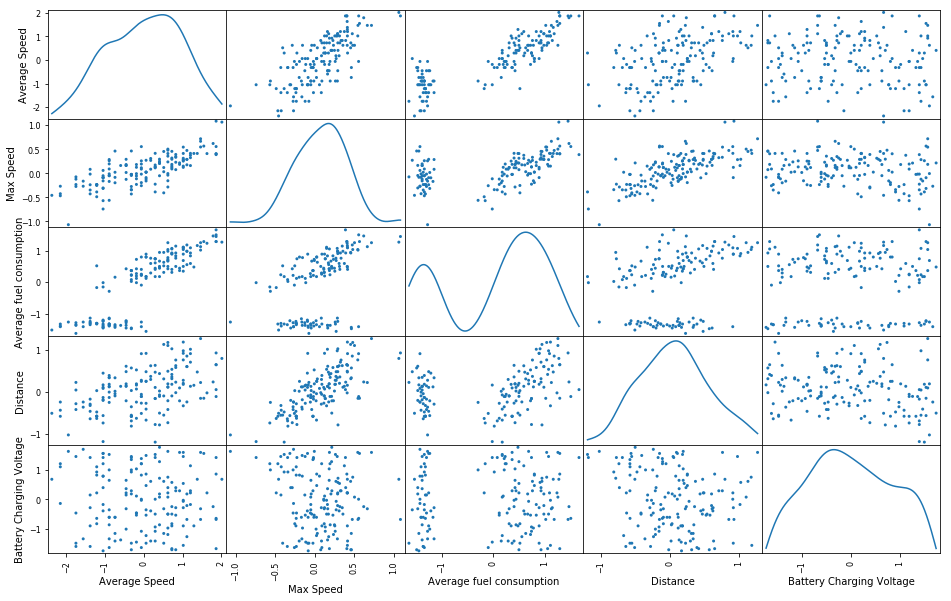

In [21]:
# produce a feature-wise correlation heatmap of the dataset
sns.heatmap(processedDrivingData.corr(), annot=True)

# produce a scatter plot matrix for each pair of features in the data
pd.plotting.scatter_matrix(processedDrivingData, alpha=1,figsize = (16,10), diagonal = 'kde');

# 2. Data transformation to lower-dimensional space to reveal the hidden structure and pattern

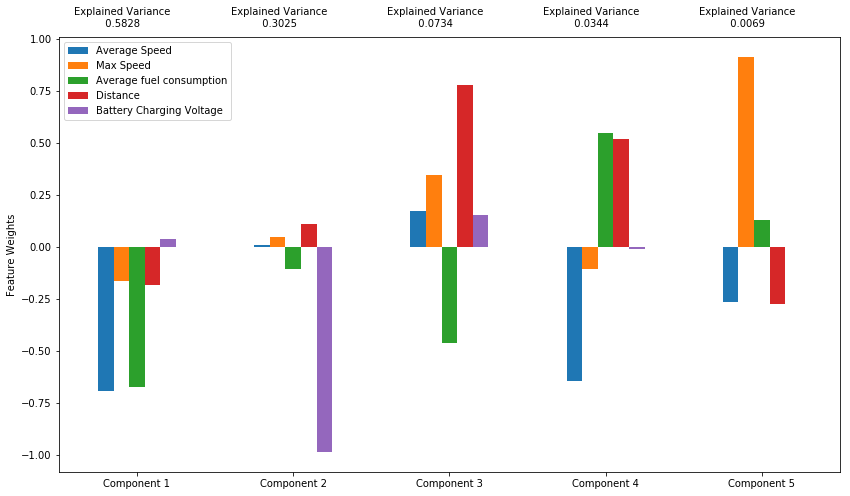

In [22]:
# TODO: Apply PCA by fitting the processed driving data with the same number of dimensions as features
# Instantiate
pca = PCA(n_components=processedDrivingData.shape[1])
# Fit
pca.fit(processedDrivingData)


# Generate PCA results plot
pcaResults = visualizePCAResults(processedDrivingData, pca)

The PCA analysis helped to identify some key relationships between features. The knowledge on feature relationship can help formulate the modelling assumptions and test relevant hypothesese. For instance, PCA component captured the strongest variation across four features namely Average Speed, Average fuel consumption, Max Speed and Distance. It is fairly plausible to assume that these features are correlated in majority of the samples, specially Average Speed and Fuel Consumption, Max Speed and Distance. It is also practically relevant since speed is proportional to fuel consumption as well as more fuel burnt could imply more distance covered. The second component captured samples showing the second largest variation in Battery Charging Voltage. Altogether the first two components already explained more than 88% of the variation in the data. Whereas remaining three components capture smallest variation for individual features. 

More robust and reliable conclusions can be drawn by selecting the number of components in a principled way (for example using cross validation or Bayesian PCA)

In [23]:
# DataFrame of results
display(pcaResults)

# DataFrame
display(type(pcaResults))

# Cumulative explained variance should add to 1
display(pcaResults['Explained Variance'].cumsum())


,Explained Variance,Average Speed,Max Speed,Average fuel consumption,Distance,Battery Charging Voltage
Component 1,0.5828,-0.6950,-0.1620,-0.6751,-0.1830,0.0393
Component 2,0.3025,0.0073,0.0495,-0.1063,0.1085,-0.9871
Component 3,0.0734,0.1724,0.3483,-0.4637,0.7810,0.1545
Component 4,0.0344,-0.6457,-0.1081,0.5492,0.5193,-0.0122
Component 5,0.0069,-0.2651,0.9156,0.1276,-0.2741,0.0001


pandas.core.frame.DataFrame

Component 1    0.5828
Component 2    0.8853
Component 3    0.9587
Component 4    0.9931
Component 5    1.0000
Name: Explained Variance, dtype: float64

,Component 1,Component 2
CarID,,
1,-2.384513,1.588541
2,1.182515,0.524129
3,1.660110,-1.406044
4,-2.285913,-0.886126
5,-0.439663,0.488521


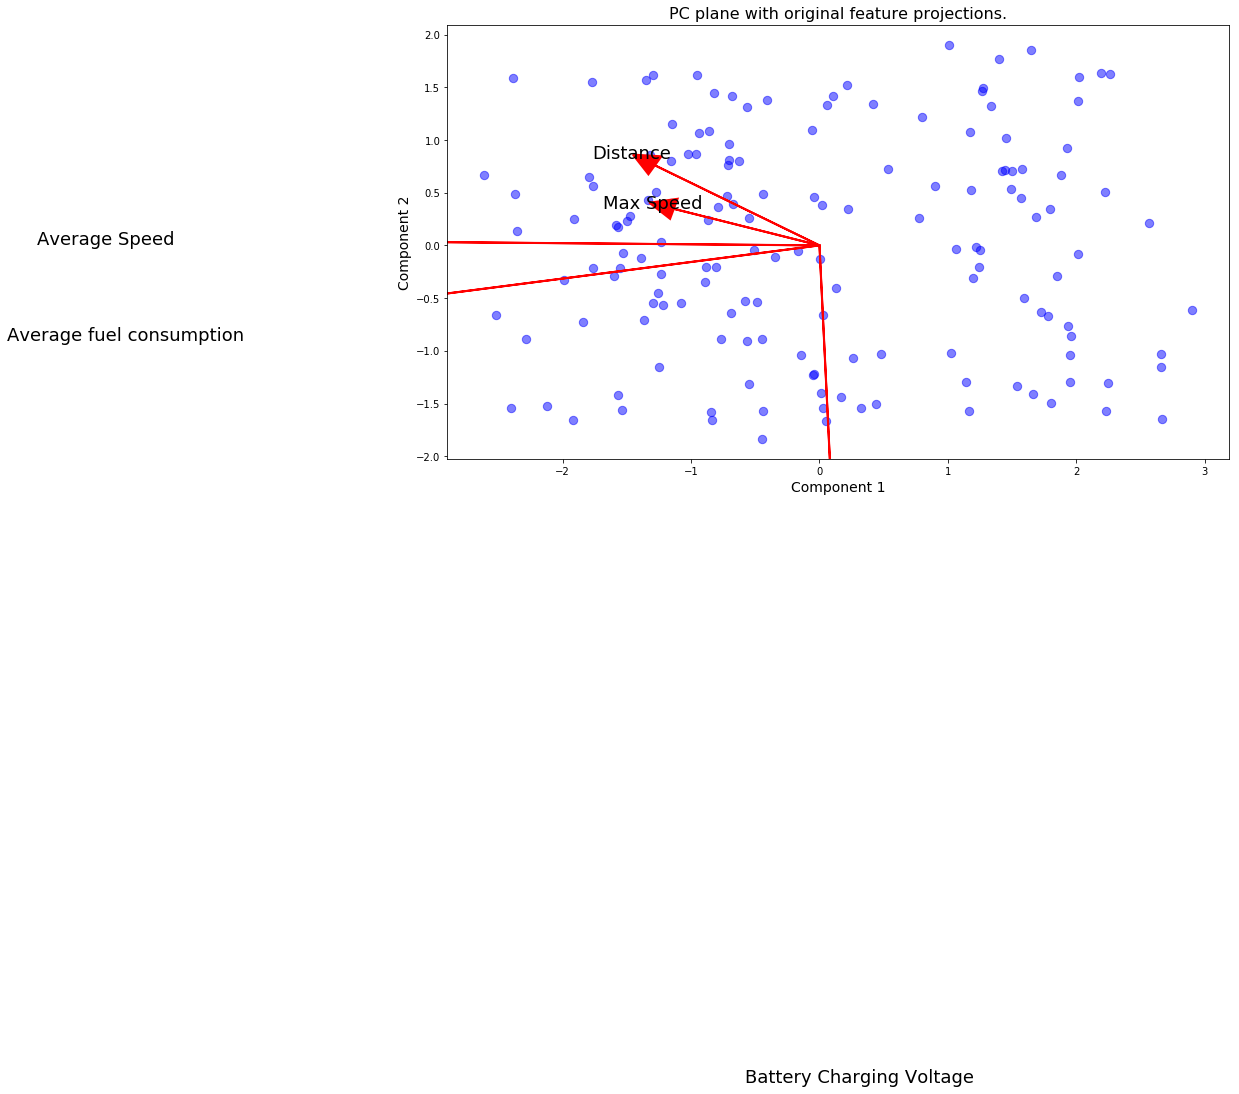

In [24]:

pca = PCA(n_components=2)
# Fit
pca.fit(processedDrivingData)

pcaTransformedData = pca.transform(processedDrivingData)



pcaTransformedData = pd.DataFrame(pcaTransformedData, columns = ['Component 1', 'Component 2'])

visualizeBiPlot(processedDrivingData, pcaTransformedData, pca)

pcaTransformedData.index=processedDrivingData.index

pcaTransformedData.head(5)

Exploratory analysis using PCA revealed interesting pattern hidden in the data. The projections or transformation of the raw data on to the first two compoments already give hints on the underlying segments. For instance, the above figure shows the that may be three segments in the data set. First segment or cluster group samples based on Average fuel consumption and Average Speed, while the second segment clusters samples based on Max Speed and Distance and the third segment comprise of sample based on Battery Cahrging Voltage. 

Since this is an exploratory analysis, we cannot make any generalizable claims. Next, I adopted a generative machine learning model to infer unbiased data-driven predictions. 


# 3. Automatic model complexity selection using Bayesian GMM

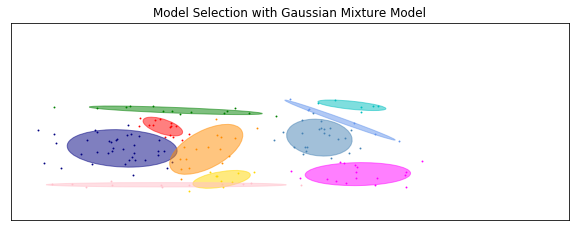

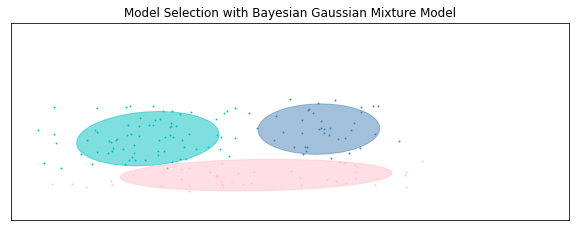

In [25]:
# Fit a Gaussian mixture with EM using ten components on complete dataset
gmm = mixture.GaussianMixture(n_components=10, covariance_type='full', max_iter=500,n_init=5, random_state=1111).fit(np.array(pcaTransformedData))


# Fit a Dirichlet process Bayesian Gaussian mixture using ten components on complete dataset
bayesianGMM = mixture.BayesianGaussianMixture(n_components=10,
                                        covariance_type='full',max_iter=500,n_init=5, init_params='random',
                                                  weight_concentration_prior_type='dirichlet_distribution',
                                              random_state=1111).fit(np.array(pcaTransformedData))

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange', 'red', 'magenta', 'steelblue', 
                              'pink','green'])
visualizeSegments(np.array(pcaTransformedData), gmm.predict(pcaTransformedData), gmm.means_, gmm.covariances_, 0,
             'Model Selection with Gaussian Mixture Model')
visualizeSegments(np.array(pcaTransformedData), bayesianGMM.predict(pcaTransformedData), bayesianGMM.means_, bayesianGMM.covariances_, 1,
             'Model Selection with Bayesian Gaussian Mixture Model')

plt.show()

The above figure demonstrates the usefulness of the Bayesian GMM over traditional GMM. Both models have access to ten components with which to fit the data.  The standard GMM model unnecessarily used all ten components while the Bayesian GMM model effectively only used as many as are needed to fully explain the variation is the data. Here we can notice that the GMM model splits some components arbitrarily, because it is trying to fit too many components, while the Dirichlet Process prior based Bayesian GMM model adapts model complexity automatically.

This figure doesn’t show it, as we’re in a low-dimensional space, but another advantage of the Bayesian GMM model is that it can fit full covariance matrices effectively even when there are less examples per segment than there are dimensions in the data, due to regularization properties of the model.

The above analysis was performed to show the proof-of-concept difference between the standard and Bayesian GMM model. I next performed a cross-validation procedure to obtain more robust and generalizable estimates on the true number of model components. 


In [26]:
def computeCVLogLikelihood(X,nComponents):
    
    
    ####Quite time consuming, use other covariance_type to 'diag', 'tied' or spherical for speed-up
    #to run the CV process quickly, set max_iter to 5000 and n_init=10
    #for quick runs, set set max_iter to 1000 and n_init=1
    
    gmm = mixture.GaussianMixture(covariance_type='full', max_iter=500,n_init=5, random_state=1111)
    bayesianGMM = mixture.BayesianGaussianMixture(covariance_type='full', max_iter=500,n_init=5, init_params='random',
                                                  weight_concentration_prior_type='dirichlet_distribution',
                                                  random_state=1111)

    gmm_LL, bayesianGMM_LL = [], []
    for n in nComponents:
        gmm.n_components = n
        bayesianGMM.n_components = n
        bayesianGMM_LL.append(np.mean(cross_val_score(bayesianGMM, X, cv=10)))
        gmm_LL.append(np.mean(cross_val_score(gmm, X, cv=10)))

    return gmm_LL, bayesianGMM_LL



In [27]:
nComponents = range(1,11)

gmm_LL, bayesianGMM_LL = computeCVLogLikelihood(pcaTransformedData,nComponents)


In [28]:
n_components_gmm = nComponents[np.argmax(gmm_LL)]
n_components_bgmm = nComponents[np.argmax(bayesianGMM_LL)]

best n_components by GMM CV = 2
best n_components by Bayesian GMM CV = 3


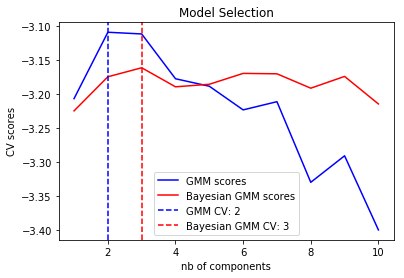

In [29]:
print("best n_components by GMM CV = %d" % n_components_gmm)
print("best n_components by Bayesian GMM CV = %d" % n_components_bgmm)


plt.figure()
plt.plot(nComponents, gmm_LL, 'b', label='GMM scores')
plt.plot(nComponents, bayesianGMM_LL, 'r', label='Bayesian GMM scores')
plt.axvline(n_components_gmm, color='b',
            label='GMM CV: %d' % n_components_gmm, linestyle='--')
plt.axvline(n_components_bgmm, color='r',
            label='Bayesian GMM CV: %d' % n_components_bgmm,
            linestyle='--')

plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='best')
plt.title('Model Selection')

plt.show()

The CV experiments clearly demosntrated the usefulness of Bayesian GMM to automatically select the number of components. Since, the standard GMM uses all the components to fit the data, resultantly starts to overfit with increasing number of components. Whereas Bayesian GMM only uses the components needed to model the data and shut-down excessive components without compromising the accuracy. 

In [30]:
# Fit a Dirichlet process Bayesian Gaussian mixture on complete dataset
bayesianGMM = mixture.BayesianGaussianMixture(n_components=n_components_bgmm,
                                        covariance_type='full', max_iter=500,n_init=5, init_params='random',
                                                  weight_concentration_prior_type='dirichlet_distribution',
                                                  random_state=1111).fit(np.array(pcaTransformedData))


In [31]:
prediction = pd.DataFrame(bayesianGMM.predict(pcaTransformedData)+1, columns=['Segments ID'])

In [32]:
prediction.index = pcaTransformedData.index

In [33]:
prediction

,Segments ID
CarID,
1,3
2,2
3,1
4,3
5,3
6,1
7,3
8,2
9,1


In [34]:
#adding the outlier samples to complete the predictions for all 165 samples

finalPredictions = pd.DataFrame(index=pd.Series(np.arange(1,166)), columns=['Segments ID'])
finalPredictions.index.names = ['CarID']
finalPredictions
finalPredictions.loc[prediction.index] = prediction
finalPredictions

,Segments ID
CarID,
1,3
2,2
3,1
4,3
5,3
6,1
7,3
8,2
9,1


In [35]:
finalPredictions.to_csv(path_or_buf='Segementation.csv',na_rep='Outlier',header=True,sep='\t')